---
title: How TSEB works? 
subject: Tutorial
subtitle: A quick overview of low-level code
short_title: TSEB
authors:
  - name: Héctor Nieto
    affiliations:
      - Instituto de Ciencias Agrarias, ICA
      - CSIC
    orcid: 0000-0003-4250-6424
    email: hector.nieto@ica.csic.es
  - name: Benjamin Mary
    affiliations:
      - Insituto de Ciencias Agrarias
      - CSIC
    orcid: 0000-0001-7199-2885
license: CC-BY-SA-4.0
keywords: TSEB, radiation, Beer-Lambert law, albedo
---

# Summary
This interactive Jupyter Notebook has the objective of showing the implemenation of TSEB-PT model in the [pyTSEB package](https://github.com/hectornieto/pyTSEB).

# Instructions
Read carefully all the text and follow the instructions.

Once each section is read, run the jupyter code cell underneath (marked as `In []`) by clicking the icon `Run`, or pressing the keys SHIFT+ENTER of your keyboard. A graphical interface will then display, which allows you to interact with and perform the assigned tasks.

To start, please run the following cell to import all the packages required for this notebook. Once you run the cell below, an acknowledgement message, stating all libraries were correctly imported, should be printed on screen.

In [1]:
%matplotlib inline
from pathlib import Path
from ipywidgets import interact, interactive, fixed, widgets
from IPython.display import display
import numpy as np
from pyTSEB import TSEB
print("Libraries imported!")

Libraries imported!


# The TSEB model

The Two-Source Energy Balance (TSEB) model [Norman et al. (1995)](https://doi.org/10.1016/0168-1923(95)02265-Y) was specifically designed to account for directionality of radiometric temperature measurements and to avoid the use of any empirical "excess" resistance terms in the model. TO achieve this, both the heat and water fluxes are separated into a soil and canopy layer, with a set of resistances set in series.

:::{note}
In [Norman et al. (1995)](https://doi.org/10.1016/0168-1923(95)02265-Y) the original resistance scheme was in parallel
:::
    
:::{figure} ./input/figures/tseb.jpg
:alt:Two Source Energy Balance model
:name:tseb-model
Schematic diagram of the TSEB model resistance network for sensible heat flux and the basic set of equations used to obtain an iterative solution. Source: [Kustas et al. (2018)](https://doi.org/10.1175/BAMS-D-16-0244).
:::

Energy fluxes are therefore split into soil and canopy, considering the conservation of energy:
    
:::{math}
:label:eq-eb
  R_{n} & \approx H + \lambda E + G\\
  R_{n,S} & \approx H_{S} + \lambda E_{S} + G\\
  R_{n,C} & \approx H_{C} + \lambda E_{C}\label{eq:Energy_Balance_TSEB}
:::

with $R_n$ being the net radiation, $H$ the sensible heat flux, $\lambda E$ the latent heat flux or evapotranspiration, and $G$ the soil heat flux (all fluxes are expressed in W m$^{-2}$. The approximation in Eq. \ref{eq:Energy_Balance} reflects additional components of the energy balance that are usually neglected, such as heat advection, storage of energy in the canopy layer or energy for the fixation of CO$_2$, which are not computed by the model.
    
Remote sensing Energy Balance Models, REBMs, rely on the ability of the radiometric information to estimate, net radiation, soil heat flux and sensible heat flux [(Norman et al., 1995)](https://doi.org/10.1016/0168-1923(95)02265-Y). To see how pyTSEB works we will run several pieces of code to estimate each of the components of the energy balance.

# Implementation with actual data in [pyTSEB](https://github.com/hectornieto/pyTSEB)

We have several GRAPEX sites with micrometeorological measurements that we will use in this and in future exercises. By running TSEB at hourly timesteps we could get a better overview of its behaviour, challenges and limitations.

:::{note}
Running pyTSEB over an image follows exactly the same procedure as all the pixels, or dates in the case of tabulated timeseries, are converted to a vectorized array for computing efficiency.
:::

:::{table}
:name: tab-site-description
Description of GRAPEX sites

Site | Latitude | Longitude | Elevation (m) | Row direction (deg.) | Row spacing (m) | Min. height (m) | Max. height (m) | Min. width (m) | Max. width (m) | TA height (m) | WS height (m)
:-- | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --:
Ripperdan 720-1 | 36.849 | -120.176 | 61 | 90 | 3.35 | 1.2 | 2.2 | 0.5 | 2.25 | 4 | 4
Ripperdan 720-2 | 36.849 | -120.174 | 61 | 90 | 3.35 | 1.2 | 2.2 | 0.5 | 2.25 | 4 | 4
Ripperdan 720-3 | 36.848 | -120.176 | 61 | 90 | 3.35 | 1.2 | 2.2 | 0.5 | 2.25 | 4 | 4
Ripperdan 720-4 | 36.848 | -120.174 | 61 | 90 | 3.35 | 1.2 | 2.2 | 0.5 | 2.25 | 4 | 4
Barrelli_007 | 38.753 | -122.98 | 113 | 135 | 3.35 | 1.25 | 2.3 | 0.5 | 1.8 | 4 | 4
Barrelli_012 | 38.751369 | -122.974658 | 112 | 45 | 3.35 | 1.25 | 2.3 | 0.5 | 1.8 | 4.4 | 4.4
Sierra Loma-north | 38.289338 | -121.117764 | 38 | 90 | 3.35 | 1.42 | 2.25 | 0.5 | 2.6 | 5 | 5
Sierra Loma-south | 38.280488 | -121.117597 | 37 | 90 | 3.35 | 1-42 | 2.25 | 0.5 | 2 | 5 | 5
Ripperdan 760 | 36.839025 | -120.21014 | 58 | 90 | 2.74 | 1.2 | 2.5 | 0.5 | 1.8 | 5.5 | 5
Barrelli_016 | 38.747 | -122.963 | 112 | 135 | 3.35 | 1.25 | 2.3 | 0.5 | 1.8 | 4 | 4
:::

In future exercises you could have the chance to process all sites, or those of interest for you. However, for this first exercise and to keep things simpler we will stick to Ripperdam 720-4, since some deficit irrigation events happened in some years [(see Nieto et al., 2022)](https://doi.org/10.1007/s00271-022-00790-2)

::::{seealso}
:class:dropdown
This is a full description of the EC column fields:

[](./fluxnet2015_variables.md)
::::

## Read the LAI and Micrometeorology data
We will read and merge the [input micrometeorology](./input/meteo/FLX_US-rip720_4_FLUXNET2015_SUBSET_HR.csv) and [input LAI](./input/canopy/FLX_US-rip720_4_FLUXNET2015_AUXCANOPY_DD.csv) ASCII files. 

:::{seealso}
:class:dropdown
A detailed description of the Eddy Covariance measurements and their post-
processing is described by [Alfieri et al. (2019b)](https://doi.org/10.1007/s00271-018-0599-3).

Estimates of daily LAI were obtained from training MODIS LAI (MCD15A3H) product and Landsat surface
reflectance using the reference based approach by [Gao et al. (2012)](https://doi.org/10.3390/rs4113287) and adapted for vineyards by [Kang et al. (2022)](https://doi.org/10.1007/s00271-022-00798-8)
:::

In [2]:
# Set the site shortname to be processed
site = "rip720_4"

# Import Python libraries
from pathlib import Path
import pandas as pd

# Set the LAI and readiation folders
input_dir = Path().absolute() / "input"
lai_dir = input_dir / "canopy"
ec_dir = input_dir / "meteo"
# Set the input files based on the chosen site
lai_filename = lai_dir / f"FLX_US-{site}_FLUXNET2015_AUXCANOPY_DD.csv"
ec_filename = ec_dir / f"FLX_US-{site}_FLUXNET2015_SUBSET_HR.csv"
print(f"LAI file path is {lai_filename}")
print(f"EC file path is {ec_filename}")

# Read the LAI and radiation tables
lai = pd.read_csv(lai_filename, sep=";", na_values=-9999)
ec = pd.read_csv(ec_filename, sep=";", na_values=-9999)

# Merge both tables by date
ec["TIMESTAMP"] = pd.to_datetime(ec["TIMESTAMP"], format="%Y%m%d%H%M")
lai["DATE"] = pd.to_datetime(lai["TIMESTAMP"], format="%Y%m%d").dt.date
lai = lai.drop(labels=["TIMESTAMP"], axis=1)
ec["DATE"] = ec["TIMESTAMP"].dt.date
ec = ec.merge(lai, on="DATE")

# We discard all cases at night (SW_IN <=0)
ec = ec[ec["SW_IN"] > 0]

# Convert Celsius to Kelvin
ec["TA"] = ec["TA"] + 273.15
# Convert kPa to hPa
ec["PA"] = 10 * ec["PA"]

# Evaluate different energy balance closure corrections
ec["H_RES"] = ec["NETRAD"] - ec["G"] - ec["LE"]
ec['LE_RES'] = ec['NETRAD'] - ec['G'] - ec['H']
ec["LE_BR"], ec["H_BR"] = TSEB.met.bowen_ratio_closure(ec["NETRAD"], ec["G"],
                                                       ec["H"], ec["LE"])
# Mean of uncorrected, ressidual and Bowen Ratio
ec["H_ENS"] = np.nanmean([ec["H_RES"], ec["H_BR"], ec['H']], axis=0)
ec["LE_ENS"] = np.nanmean([ec["LE_RES"], ec["LE_BR"], ec['LE']], axis=0)

LAI file path is /Users/vicenteburchard/Nextcloud/1_Projects/ILINK24/Workshop_3SEB_UCDavis/py3SEB-workshop/input/canopy/FLX_US-rip720_4_FLUXNET2015_AUXCANOPY_DD.csv
EC file path is /Users/vicenteburchard/Nextcloud/1_Projects/ILINK24/Workshop_3SEB_UCDavis/py3SEB-workshop/input/meteo/FLX_US-rip720_4_FLUXNET2015_SUBSET_HR.csv


/var/folders/1_/y0yzlfqx3m75gf1153l99fv00000gn/T/ipykernel_19759/1229335458.py:43: RuntimeWarning: Mean of empty slice
  ec["H_ENS"] = np.nanmean([ec["H_RES"], ec["H_BR"], ec['H']], axis=0)
/var/folders/1_/y0yzlfqx3m75gf1153l99fv00000gn/T/ipykernel_19759/1229335458.py:44: RuntimeWarning: Mean of empty slice
  ec["LE_ENS"] = np.nanmean([ec["LE_RES"], ec["LE_BR"], ec['LE']], axis=0)


## Net shortwave radiation
To compute the net shortwave radiation and its partitioning between the canopy and the soil we are using the model of [Campbell and Norman, 1998, Chapter 15](https://doi.org/10.1007/978-1-4612-1626-1). The key aspect of this model is the calculation of the trasmitted shortwave radiation throught the canopy ($\Tau_C$)

:::{seealso}
:class:dropdown
The full description of the radiation model can be found in [Campbell and Norman, 1998, Chapter 15](https://doi.org/10.1007/978-1-4612-1626-1_15)
:::

The transmittance of shortwave radiation through the canopy depends on the wavelength due to vegetation absorbing a greater portion of the photosynthetically active radiation (PAR, 400–700 nm spectrum) than near-infrared radiation (NIR, 700–2500 nm spectrum) wavelengths. ($\Tau_C$ is partitioned into two components (direct/diffse) and in two spectral band (PAR/NIR)

:::{note}
:class:dropdown
We could include more spectral bands, such as (PAR/NIR/SWIR), with a slight increase of computational cost. 
:::

The direct-beam spectral (transmittance ($\tau_{C,DIR,\lambda}$) at a given solar zenith angle ($\theta_S$) is calculated following the equations of Campbell and Norman (1998) for a single layer crop:

:::{math}
:label:eq-tau-dir
\tau_{C,DIR,\lambda}\left(\theta_S\right)=\frac{\left(\rho_{C,\lambda}^*\left(\theta_S\right)^2 - 1\right)\exp \left( -\sqrt{\zeta_\lambda} \kappa_{b}\left(theta_S\right)LAI\right)}{\left(\rho_{C,\lambda}^*\rho_{S,\lambda} - 1\right) + \rho_{C,\lambda}^*\left(\psi\right)\left(\rho_{C\lambda}^*\left(\theta_S\right) - \rho_{S,\lambda}\right)\exp \left( -2\sqrt {\zeta_\lambda \kappa_{b}\left(\theta_S\right)LAI} \right)}
:::

with ($\lambda$) being either the PAR or NIR. $\rho_{C,\lambda}^*\left(\psi\right)$ is the beam spectral reflection coefficient for a deep canopy with non-horizontal leaves (see Eq. [](#eq-rho-star)), $\zeta_\lambda$ is the leaf absortivity, $\kappa_{b}$ is the extinction coefficient for direct-beam radiation (per LAI unit), and $\rho_{S,\lambda}$ is the soil spectral reflectance. The multiple scattering between the soil and the canopy is accounted for in the $\rho _{C,\lambda}^*$ and $\rho_{S,\lambda}$ terms.

:::{math}
:label:eq-rho-star
\rho_{C,\lambda}^*\left(\theta_S\right)=\frac{2\kappa_b\left(\theta_S\right) \rho_\lambda^H}{\kappa_b\left(\theta_S\right)+1}
:::

$\rho_\lambda^H=\frac{1 - \sqrt{\zeta_\lambda}}{1+\sqrt{\zeta_\lambda}}$ is the reflectance factor for a canopy with horizontal leaves.

Finally, the canopy beam extinction $\kappa_b\left(\psi\right)$ is calculated based on the ellipsoidal LADF of [Campbell (1990)](https://doi.org/10.1016/0168-1923(90)90030-A)

:::{math}
:label:eq-kbe
\kappa_b\left(\theta_S\right)=\frac{\sqrt{\chi^2+ \tan^2\theta_S}}{\chi+1.774\left(\chi+1.182\right)^{-0.733}}
:::

Diffuse spectral transmittance ($\tau_{C,DIF,\lambda}$) is calculated by numerically integrating $\kappa_b$ over the hemisphere 

:::{math}
:label:eq-kd
\kappa_d =2 \int_0^\pi\kappa_b\left(\psi\right) \sin\psi \cos\psi d\psi
:::
and replacing $\kappa_b$ by $\kappa_d$ in Eq. [](#eq-tau-dir)

Similarly the canopy direct spectral albedo is computed as:
:::{math}
:label:eq-rho-dir
\rho_{C,DIR,\lambda}\left(\theta_S\right)=\frac{\rho_{C,\lambda}^*\left(\theta_S\right) + \left[\frac{\rho_{C,\lambda}^*\left(\theta_S\right) - \rho_{S,\lambda}}{\rho_{C,\lambda}^*\left(\theta_S\right)\rho_{s,\lambda} -1}\right] \exp\left(-2\sqrt{\zeta_\lambda}\kappa_b\left(\theta_S\right)LAI\right)}{1 + \rho_{C,\lambda}^*\left(\theta_S\right) + \left[\frac{\rho_{C,\lambda}^*\left(\theta_S\right) - \rho_{s,\lambda}}{\rho_{C,\lambda}^*\left(\theta_S\right)\rho_{S,\lambda} -1}\right] \exp\left(-2\sqrt{\zeta_\lambda}\kappa_b\left(\theta_S\right)LAI\right)}
:::
and the diffuse canopy albedo ($\rho_{C,DIF,\lambda}$) by replacing $\kappa_b\left(\theta_S\right)$ by $\kappa_d$

Therefore as inputs for computin net shortwave radiation we need to provide as input forcing the solar irradiance, direct and diffuse in the PAR and NIR, and then as main input the $LAI$, followed by soil and leaf spectra and [Campbell (1990)](https://doi.org/10.1016/0168-1923(90)90030-A) LIDF parameter ($\chi$). 

In this example we will simplify things and assume that the canopy is horizontally homogeneous and thus no clumping index will be compute

:::{note}
we will get into more details on this topic in the [TSEB in row crops notebook](./401-Row_crops.ipynb)
:::

:::{seealso}
:class:dropdown
The code for estimating the diffuse and bean radiation is based on {Weiss and Norman (1985}(http://dx.doi.org/10.1016/0168-1923(85)90020-6) and can be found at the [pyTSEB GitHub repository](https://github.com/hectornieto/pyTSEB/blob/382e4fc01e965143ebafdaefe5be9b45c737455a/pyTSEB/net_radiation.py#L62)

The code for running the Cambpell and Norman (1998)[] model can be found at the pyTSEB GitHub repository: [canopy spectral properties](https://github.com/hectornieto/pyTSEB/blob/382e4fc01e965143ebafdaefe5be9b45c737455a/pyTSEB/net_radiation.py#L439) and [estimation of net shortwave radiation](https://github.com/hectornieto/pyTSEB/blob/382e4fc01e965143ebafdaefe5be9b45c737455a/pyTSEB/net_radiation.py#L546C5-L546C21)
:::

In [3]:
# Site location
lat = 36.848
lon = -120.174

# The time zone is PST, which corresponds to -120 deg, time longitude
stdlon = -120

# Set the leaf and soil spectra
rho_leaf_vis = 0.054
rho_leaf_nir = 0.262
tau_leaf_vis = 0.038
tau_leaf_nir = 0.333
rho_soil_vis = 0.07
rho_soil_nir = 0.32

# Set the Cambpell chi LIDF parameter [default=1, spherical LIDF]
x_lad = 1

# The ASCII table is missing the solar angles, so we will use the calc_sun_angles function of TSEB to compute the angles based on site location and timestamp
theta, saa = TSEB.met.calc_sun_angles(
    np.full_like(ec['LAI'].values, lat),
    np.full_like(ec["LAI"].values, lon),
    np.full_like(ec["LAI"].values, stdlon),
    ec['TIMESTAMP'].dt.dayofyear.values,
    ec['TIMESTAMP'].dt.hour.values + ec['TIMESTAMP'].dt.minute.values / 60.)


# In order to esimate Estimates the direct and diffuse solar radiation based on the Weiss and Norman model
difvis, difnir, fvis, fnir = TSEB.rad.calc_difuse_ratio(ec["SW_IN"].values,
                                                        theta,
                                                        press=np.full_like(theta, 1013.15))
par_dir = fvis * (1. - difvis) * ec["SW_IN"].values
nir_dir = fnir * (1. - difnir) * ec["SW_IN"].values
par_dif = fvis * difvis * ec["SW_IN"].values
nir_dif = fnir * difnir * ec["SW_IN"].values

# Vectorize the input scalar variables
x_lad = np.full_like(ec["LAI"].values, x_lad)
rho_leaf_vis = np.full_like(ec["LAI"].values, rho_leaf_vis)
rho_leaf_nir = np.full_like(ec["LAI"].values, rho_leaf_nir)
tau_leaf_vis = np.full_like(ec["LAI"].values, tau_leaf_vis)
tau_leaf_nir = np.full_like(ec["LAI"].values, tau_leaf_nir)
rho_soil_vis = np.full_like(ec["LAI"].values, rho_soil_vis)
rho_soil_nir = np.full_like(ec["LAI"].values, rho_soil_nir)

# We append the VIS and PAR spectrum to be computationally more efficient in Numpy
rho_leaf = np.array((rho_leaf_vis, rho_leaf_nir))
tau_leaf = np.array((tau_leaf_vis, tau_leaf_nir))
rho_soil = np.array((rho_soil_vis, rho_soil_nir))

# calculate aborprtivity
amean = 1.0 - rho_leaf - tau_leaf
amean_sqrt = np.sqrt(amean)

# Calculate canopy beam extinction coefficient
lai_eff = np.asarray(ec["LAI"].values)  # So far we are assuming a homogenous canopy so the effective LAI of a clumped canopy does not vary

# D I F F U S E   C O M P O N E N T S
# Integrate to get the diffuse transmitance

taud = 0
for angle in range(0, 90, 5):
    angle = np.radians(angle)
    akd = (np.sqrt(x_lad**2 + np.tan(theta)**2) / (x_lad + 1.774 * (x_lad + 1.182)**-0.733))  # Eq. 15.4
    taub = np.exp(-akd * ec["LAI"].values)
    taud += taub * np.cos(angle) * np.sin(angle) * np.radians(5)

taud = 2.0 * taud

# Diffuse light canopy reflection coefficients  for a deep canopy
akd = -np.log(taud) / ec["LAI"].values
rcpy= (1.0 - amean_sqrt) / (1.0 + amean_sqrt)  # Eq 15.7
rdcpy = 2.0 * akd * rcpy / (akd + 1.0)  # Eq 15.8

# Diffuse canopy transmission and albedo coeff for a generic canopy (visible)
expfac = amean_sqrt * akd * ec["LAI"].values
neg_exp, d_neg_exp = np.exp(-expfac), np.exp(-2.0 * expfac)
xnum = (rdcpy * rdcpy - 1.0) * neg_exp
xden = (rdcpy * rho_soil - 1.0) + rdcpy * (rdcpy - rho_soil) * d_neg_exp
taudt = xnum / xden  # Eq 15.11
fact = ((rdcpy - rho_soil) / (rdcpy * rho_soil - 1.0)) * d_neg_exp
albd = (rdcpy + fact) / (1.0 + rdcpy * fact)  # Eq 15.9

# B E A M   C O M P O N E N T S
# Direct beam extinction coeff (spher. LAD)
akb = (np.sqrt(x_lad**2 + np.tan(theta)**2) / (x_lad + 1.774 * (x_lad + 1.182)**-0.733))  # Eq. 15.4

# Direct beam canopy reflection coefficients for a deep canopy
rbcpy = 2.0 * akb * rcpy / (akb + 1.0)  # Eq 15.8
# Beam canopy transmission and albedo coeff for a generic canopy (visible)
expfac = amean_sqrt * akb * lai_eff
neg_exp, d_neg_exp = np.exp(-expfac), np.exp(-2.0 * expfac)
xnum = (rbcpy * rbcpy - 1.0) * neg_exp
xden = (rbcpy * rho_soil - 1.0) + rbcpy * (rbcpy - rho_soil) * d_neg_exp
taubt = xnum / xden  # Eq 15.11
fact = ((rbcpy - rho_soil) / (rbcpy * rho_soil - 1.0)) * d_neg_exp
albb = (rbcpy + fact) / (1.0 + rbcpy * fact)  # Eq 15.9

taubt, taudt, albb, albd, rho_soil = map(np.array,
                                         [taubt, taudt, albb, albd, rho_soil])

taubt[np.isnan(taubt)] = 1
taudt[np.isnan(taudt)] = 1
albb[np.isnan(albb)] = rho_soil[np.isnan(albb)]
albd[np.isnan(albd)] = rho_soil[np.isnan(albd)]

# Compute the canopy and soil net radiation using Cambpell RTM
sn_c = ((1.0 - taubt[0]) * (1.0- albb[0]) * par_dir
            + (1.0 - taubt[1]) * (1.0- albb[1]) * nir_dir
            + (1.0 - taudt[0]) * (1.0- albd[0]) * par_dif
            + (1.0 - taudt[1]) * (1.0- albd[1]) * nir_dif)

sn_s = (taubt[0] * (1.0 - rho_soil_vis) * par_dir
            + taubt[1] * (1.0 - rho_soil_nir) * nir_dir
            + taudt[0] * (1.0 - rho_soil_vis) * par_dif
            + taudt[1] * (1.0 - rho_soil_nir) * nir_dif)

print("Finished the computation of net shortwave radiation")

Finished the computation of net shortwave radiation


/var/folders/1_/y0yzlfqx3m75gf1153l99fv00000gn/T/ipykernel_19759/2774368568.py:71: RuntimeWarning: divide by zero encountered in log
  akd = -np.log(taud) / ec["LAI"].values
/var/folders/1_/y0yzlfqx3m75gf1153l99fv00000gn/T/ipykernel_19759/2774368568.py:73: RuntimeWarning: invalid value encountered in divide
  rdcpy = 2.0 * akd * rcpy / (akd + 1.0)  # Eq 15.8


### Evaluate net shortwave radiation

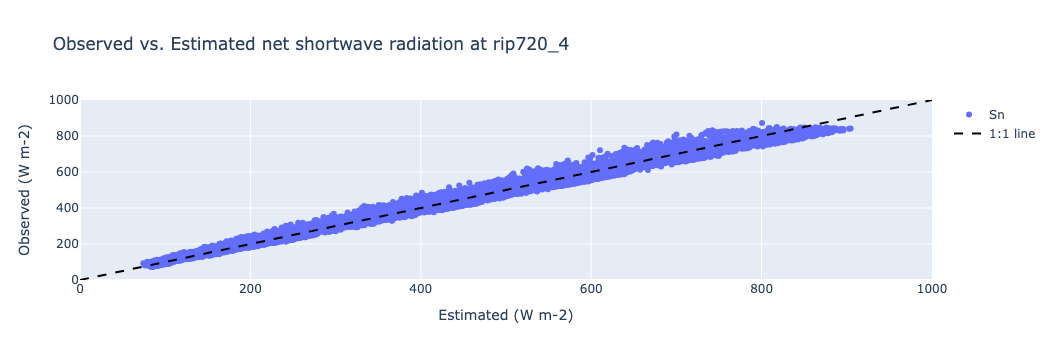

In [4]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
daytime = ec["SW_IN"] > 100

sn_model = sn_c + sn_s
sn_obs = ec["SW_IN"].values - ec["SW_OUT"].values

fig = go.Figure()
fig.add_trace(go.Scatter(x=sn_model[daytime], y=sn_obs[daytime], 
                         name="Sn", mode="markers"))
fig.add_trace(go.Scatter(x=[0, 1000], y=[0, 1000], mode="lines", name="1:1 line", line={"color": "black", "dash": "dash"}))
fig.update_layout(title_text=f"Observed vs. Estimated net shortwave radiation at {site}",
                  yaxis_range=[0, 1000], xaxis_range=[0, 1000],
                  xaxis_title="Estimated (W m-2)", yaxis_title="Observed (W m-2)")

## Net longwave radiation
The net longwave radiation a priori is much simpler as we assume that all emitted and indident longwave radiation is diffuse. In pyTSEB we follow a similar approach as the one described in [Kustas and Norman (1999)](https://doi.org/10.1016/S0168-1923(99)00005-2) for partially vegetated surfaces, which also partitions net longwave radiation into the soil ($L_{n,S}$) and the canopy components ($L_{n,C}$). The only difference between pyTSEB and the formulation of [Kustas and Norman (1999)](https://doi.org/10.1016/S0168-1923(99)00005-2) is that we incorporate longwave scattering between the soil and the canopy:


:::{math}
L_{n,S} &= \epsilon_S \kappa_l LAI L_{sky} + \epsilon_S \left(1.0 - \kappa_l LAI * L_{sky} \right) L_C - L_S\\
L_{n,C} &= \epsilon_C \left(1.0 - \kappa_l LAI * L_{sky}\right) \left(L_{sky} + L_S\right) - 2.0 \left(1.0 - \kappa_l LAI\right) L_C
:::

where $L_{sky}$ is the downwelling atmospheric longwave irradiance, $L_S$ and $L_C$ are the longwave emission of respectively soil and canopy layers, $\kappa_l$ is analogous to the shortwave diffuse transmittance ($\kappa_d$) and thus it can be calculated from Eq. [](#eq-kd), $\epsilon_S$ is soil emisivity and $\epsilon_C$ can be derived from Eq. [](#eq-rho-dir) ($\epsilon_C = 1 - \rho_{C,DIF,l}$) and leaf emissivity.

:::{note}
Even we use a modified version of [Kustas and Norman (1999)](https://doi.org/10.1016/S0168-1923(99)00005-2), the pyTSEB package also includes the original formulation [here](https://github.com/hectornieto/pyTSEB/blob/382e4fc01e965143ebafdaefe5be9b45c737455a/pyTSEB/net_radiation.py#L244)
:::

However, $L_S$ and $L_C$ depend respectively on soil and canopy temperature, which at this stage is an unknown. For that reason the application of this equation is done internaly when deriving the component temperature and sensible heat fluxes (see the upcoming Section [](#sec-h))



In [5]:
def calc_L_n_Campbell(T_C, T_S, L_dn, lai, emisVeg, emisGrd, x_LAD=1):
    ''' Net longwave radiation for soil and canopy layers

    Estimates the net longwave radiation for soil and canopy layers unisg based on equation 2a
    from [Kustas1999]_ and incorporated the effect of the Leaf Angle Distribution based on [Campbell1998]_

    Parameters
    ----------
    T_C : float
        Canopy temperature (K).
    T_S : float
        Soil temperature (K).
    L_dn : float
        Downwelling atmospheric longwave radiation (w m-2).
    lai : float
        Effective Leaf (Plant) Area Index.
    emisVeg : float
        Broadband emissivity of vegetation cover.
    emisGrd : float
        Broadband emissivity of soil.
    x_LAD: float, optional
        x parameter for the ellipsoidal Leaf Angle Distribution function,
        use x_LAD=1 for a spherical LAD.

    Returns
    -------
    L_nC : float
        Net longwave radiation of canopy (W m-2).
    L_nS : float
        Net longwave radiation of soil (W m-2).

    References
    ----------
    .. [Kustas1999] Kustas and Norman (1999) Evaluation of soil and vegetation heat
        flux predictions using a simple two-source model with radiometric temperatures for
        partial canopy cover, Agricultural and Forest Meteorology, Volume 94, Issue 1,
        Pages 13-29, http://dx.doi.org/10.1016/S0168-1923(99)00005-2.
    '''

    # calculate long wave emissions from canopy, soil and sky
    L_C = emisVeg * met.calc_stephan_boltzmann(T_C)
    L_C[np.isnan(L_C)] = 0
    L_S = emisGrd * met.calc_stephan_boltzmann(T_S)
    L_S[np.isnan(L_S)] = 0
    # Calculate the canopy spectral properties
    _, albl, _, taudl = calc_spectra_Cambpell(lai,
                                              np.zeros(emisVeg.shape),
                                              1.0 - emisVeg,
                                              np.zeros(emisVeg.shape),
                                              1.0 - emisGrd,
                                              x_lad=x_LAD,
                                              lai_eff=None)

    # calculate net longwave radiation divergence of the soil
    L_nS = emisGrd * taudl * L_dn + emisGrd * (1.0 - taudl) * L_C - L_S
    L_nC = (1 - albl) * (1.0 - taudl) * (L_dn + L_S) - 2.0 * (1.0 - taudl) * L_C
    L_nC[np.isnan(L_nC)] = 0
    L_nS[np.isnan(L_nS)] = 0
    return np.asarray(L_nC), np.asarray(L_nS)

## Soil heat flux
Soil heat flux is usually estimated as a fraction of the soil net radiation $R_{n,S}$. Such fraction can be assumed constant along the day (e.g. $G=0.35 R_{n,S}$) or can change along the day, such as the sinusoidal function proposed by [Santanello and Friedl, 2003](https://doi.org/10.1175/1520-0450(2003)042<0851:DCISHF>2.0.CO;2). 

Since the computation of net longwave radiation is dependant of getting estimates of $T_C$ and $T_S$ and thus is computed internally in the TSEB modules during the iteration that will be discussed in the next section, $G$ is also computed within the TSEB function, being iteratevely recomputed every time a new $T_C$ and $T_S$ is obtained. The different TSEB versions in pyTSEB accept computing $G$ in four different ways:

1. As a constant ratio of $R_{n,S}$ [function `calc_G_ratio`](https://github.com/hectornieto/pyTSEB/blob/382e4fc01e965143ebafdaefe5be9b45c737455a/pyTSEB/TSEB.py#L2809)
2. As time dependent ratio of $R_{n,S}$ according to a sinusoidal function [function `calc_G_time_diff`](https://github.com/hectornieto/pyTSEB/blob/382e4fc01e965143ebafdaefe5be9b45c737455a/pyTSEB/TSEB.py#L2729)
3. As time dependent ratio of $R_{n,S}$ according to a double assymetric sigmoid function [](https://github.com/hectornieto/pyTSEB/blob/382e4fc01e965143ebafdaefe5be9b45c737455a/pyTSEB/TSEB.py#L2769)
4. As precomputed/prescribed values
 
:::{note}
This last option can be chosen to force the use of measured $G$ when running TSEB, which sometimes can be useful when testing and evaluating new (sub)modules into TSEB. 
:::



## Surface roughness
In addition, REBMs need additional ancillary inputs, such as air temperature, wind speed and canopy height or roughness. The latter accounts for the efficiency in the turbulent transport of heat and water between the land surface and the overlying air [Raupach (1994)](https://doi.org/10.1007/BF00709229)[Alfieri et al. 2019](https://doi.org/10.1007/s00271-018-0610-z) (you can revisity the  [102-Turbulence_and_sensible_heat_flux](./102-Turbulence_and_sensible_heat_flux.ipynb) notebook). Specifically for pyTSEB, vegetation structure and density are also important for estimating wind and radiation extinction through the canopy layer affecting the radiation partitioning [Parry et al. (2019)](https://doi.org/10.1007/s00271-019-00621-x) and turbulent transport of  momentum, heat  and water vapour in the canopy air space [Nieto et al. (2019)](https://doi.org/10.1007/s00271-018-0611-y).
   
In pyTSEB, depending on the plant functional trait, roughness can be estimated using different methods. For short and herbaceous crops, the typical ratio of canopy height ($h_c$) is applied:

:::{math}
:label:eq-roughness-short
d_0 &= 2/3 h_c
z_{0m} & = 1/8 h_c 
:::
where $d_0$ is the zero-plane displacement height and $z_{0m}$ is the roughness length for momentum.

For tall and woody canopies, in which leaf density and coverage can play a more importan role, pyTSEB can adopt the formulation of [Schaudt and Dickinson (2000)](http://dx.doi.org/10.1016/S0168-1923(00)00153-2.), which at the same time it relies on the model by [Raupach (1994))(https://doi.org/10.1007/BF00709229)

Since vineyards can be considered as open shrublands or short decidous broadleaved canopies, we will compute roughness based on [Schaudt and Dickinson (2000)](http://dx.doi.org/10.1016/S0168-1923(00)00153-2.). As inputs we need not only the canopy height ($h_c$), but alos the $LAI$, the fractional cover and the width-to-height canopy ratio ($w_c$)

### Estimate the structural variables based on Earth Observation LAI timeseries
These canopy structural variables could be retrieved using empirical equations derived in [Nieto et al. (2019](). These were estimated from the daily LAI using empirical curves ([](#structural-functions) fit with measured in situ values during four Intensive Observation Periods in 2015 in Sierra Loma. The empirical fits were constrained by the following boundary conditions:

* $h_c$ should tend to the height of the vine trellis when LAI tends to zero, as this is where the branches with sprouts are located:
* canopy width ($w_c$) should tend to the width of the vine trellis when LAI tends to zero, as the branches with sprouts follows a “T” pattern:
* the height of the bottom of the canopy tends to $h_c$ when LAI tends to zero. In other words, the ratio of bottom-to-top of the canopy ($h_b/h_c$) tends to 1 when LAI tends to zero.

:::{figure} ./input/figures/vineyard_structural_functions.png
:alt: Empirical structural functions
:name: structural-functions
Empirical models relating canopy height , canopy width and the bottom of the canopy with the fused STARFM LAI. Solid dots represent in situ measured values
:::

These empirical equations are coded in Python as:

In [6]:
import numpy as np

################################################################################
# Empirical equations to generate canopy structural parameters from LAI
################################################################################
def lai_2_hc(lai, hc_min):
    slope = 0.42
    hc = hc_min + slope * lai
    return hc


def lai_2_hbratio(lai, hc_min):
    hb_ratio_mean = 0.4848388065
    hb_ratio = np.zeros(lai.shape)

    hb_ratio[lai < hc_min] = 1. + ((hb_ratio_mean - 1.) / hc_min) * lai[
        lai < hc_min]
    hb_ratio[lai >= hc_min] = hb_ratio_mean

    return hb_ratio


def lai_2_width(lai, wc_min, wc_max):
    beta = 6.96560056
    offset = 1.70825736

    width = wc_min + (wc_max - wc_min) / (1.0 + np.exp(-beta * (lai - offset)))

    return width


def lai_2_fcover(lai, fc_min, fc_max):
    beta = 7.0
    offset = 1.70

    fcover = fc_min + (fc_max - fc_min) / (1.0 + np.exp(-beta * (lai - offset)))

    return fcover


def lai_2_canopy(lai, hc_min, fc_min, fc_max):
    hc = lai_2_hc(lai, hc_min)
    hb_ratio = lai_2_hbratio(lai, hc_min)
    fcover = lai_2_fcover(lai, fc_min, fc_max)

    return hc, hb_ratio, fcover

And when applied to the vine characteristics of Ripperdam 720-4 we can run this

In [7]:
# Structural characterisctos of the site
hc_min = 1.2
hc_max = 2.2
wc_min = 0.5
wc_max = 2.25
interrow = 3.35  # Interrow width (used to compute the fractional cover as w_c / interrow

# Compute the expected minimum and maximum canopy cover based on mininum and maximum canopy width
fc_min = wc_min / interrow
fc_max = wc_max / interrow
h_c, hb_ratio, f_c = lai_2_canopy(ec["LAI"].values,
                                  hc_min,
                                  fc_min,
                                  fc_max)

# Ensure that both canopy height and cover are within the limits
h_c = np.clip(h_c, hc_min, hc_max)
f_c = np.clip(f_c, 0, 1)

# canopy width
w_c = f_c * interrow
# Canopy width to height ratio
w_c_ratio = w_c / (h_c - hb_ratio * h_c)

Now, with the structural parameters define we can now compute the zero-plane displacement height and roughness length for momentum

In [8]:
# Set the site landcover type
landcover = TSEB.res.BROADLEAVED_D  # We coded different functional types based on the IGBP nomenclature

# Convert input scalars to numpy arrays
lai, h_c, w_c, landcover = map(np.asarray, (ec["LAI"].values, h_c, w_c, landcover))

# Initialize fractional cover and horizontal area index
lambda_ = np.zeros(ec["LAI"].values.shape)

# Needleleaf canopies
mask = np.logical_or(landcover == TSEB.res.CONIFER_E, landcover == TSEB.res.CONIFER_D)
lambda_[mask] = (2. / np.pi) * f_c[mask] * w_c[mask]

# Broadleaved canopies
mask = np.logical_or.reduce((landcover == TSEB.res.BROADLEAVED_E, landcover == TSEB.res.BROADLEAVED_D,
                             landcover == TSEB.res.FOREST_MIXED, landcover == TSEB.res.SAVANNA_WOODY))

lambda_[mask] = f_c[mask] * w_c[mask]

# Shrublands
mask = np.logical_or(landcover == TSEB.res.SHRUB_O, landcover == TSEB.res.SHRUB_C)
lambda_[mask] = f_c[mask] * w_c[mask]

############################################
# Calculation of the Raupach (1994) formulae
############################################
# Convert input scalar to numpy array
lambda_ = np.asarray(lambda_)
z_0m_factor = np.zeros(lambda_.shape)
d_factor = np.asarray(np.zeros(lambda_.shape) + 0.65)

# Calculation of the Raupach (1994) formulae
# if lambda_ > 0.152:
i = lambda_ > 0.152
z_0m_factor[i] = ((0.0537 / (lambda_[i]**0.510))
                 * (1. - np.exp(-10.9 * lambda_[i]**0.874)) + 0.00368)
# else:
z_0m_factor[~i] = 5.86 * np.exp(-10.9 * lambda_[~i]**1.12) * lambda_[~i]**1.33 + 0.000860
# if lambda_ > 0:
i = lambda_ > 0
d_factor[i] = 1. - (1. - np.exp(-np.sqrt(15.0 * lambda_[i]))) / np.sqrt(15.0 * lambda_[i])

##########################################
# Calculation of correction factors from  Lindroth
fz = np.asarray(0.3299 * ec["LAI"].values**1.5 + 2.1713)
fd = np.asarray(1. - 0.3991 * np.exp(-0.1779 * ec["LAI"].values))

# LAI <= 0
fz[ec["LAI"].values <= 0] = 1.0
fd[ec["LAI"].values <= 0] = 1.0

# LAI >= 0.8775:
fz[ec["LAI"].values >= 0.8775] = 1.6771 * np.exp(-0.1717 * ec["LAI"].values[ec["LAI"].values >= 0.8775]) + 1.
fd[ec["LAI"].values >= 0.8775] = 1. - 0.3991 * np.exp(-0.1779 * ec["LAI"].values[ec["LAI"].values >= 0.8775])

# Application of the correction factors to roughness and displacement
# height
z_0m_factor = np.asarray(z_0m_factor * fz)
d_factor = np.asarray(d_factor * fd)

# For crops and grass we use a fixed ratio of canopy height
mask = np.logical_or.reduce((landcover == TSEB.res.CROP, landcover == TSEB.res.GRASS,
                             landcover == TSEB.res.SAVANNA, landcover == TSEB.res.CROP_MOSAIC))
z_0m_factor[mask] = 1. / 8.
d_factor[mask] = 0.65

# Calculation of rouhgness length
z_0m = np.asarray(z_0m_factor * h_c)

# Calculation of zero plane displacement height
d_0 = np.asarray(d_factor * h_c)

# For barren surfaces (bare soil, water, etc.)
mask = np.logical_or.reduce((landcover == TSEB.res.WATER, landcover == TSEB.res.URBAN,
                             landcover == TSEB.res.SNOW, landcover == TSEB.res.BARREN))
z_0m[mask] = 0.01
d_0[mask] = 0

:::{seealso}
You can check the code implementation in pyTSEB [here](https://github.com/hectornieto/pyTSEB/blob/382e4fc01e965143ebafdaefe5be9b45c737455a/pyTSEB/resistances.py#L124)
:::

(sec-h)=
## Sensible heat flux
The key in TSEB models is the partition of sensible heat flux into the soil and canopy layers, which depends on the soil and canopy temperatures ($T_S$ and $T_C$ respectively, left side of Fig. [](#tseb)). Given the difficulty of obtaining the pure component temperatures, even with very high resolution data due to canopy gaps,[Norman et al (1995)](https://doi.org/10.1016/0168-1923(95)02265-Y) found a solution to retrieve $T_S$ and $T_C$ using a single observation of the directional radiometric temperature $T_{rad}\left(\theta\right)$ as this is the case for most of the remote sensing systems. Eq. [](#eq-TSEB_Trad) decomposes the composite $T_{rad}\left(\theta\right)$ temperature between its components $T_S$ and $T_C$, assuming blackbody emission of thermal radiance:

:::{math}
:label:eq-TSEB_Trad
\sigma T_{rad}^4\left(\theta\right)=f_c\left(\theta\right)\sigma\,T_{C}^4+\left[1-f_{c}\left(\theta\right)\right]\sigma\,T_{S}^4
:::
where $f_c\left(\phi\right)$ is the fraction of vegetation observed by the sensor. Since [](#eq-TSEB_Trad) consists of two unknowns and only one equation, an iterative process to find $H_S$, $T_S$, $H_C$ and $T_C$ is defined based upon an initial guess of potential canopy transpiration, and under the assumption that during daytime hours condensation for the soil/substrate should not occur. The initial canopy latent and sensible heat fluxes are estimated based on the [Priestley and Taylor (1972)](https://doi.org/10.1175/1520-0493(1972)100<0081:OTAOSH>2.3.CO;2) formulation for potential transpiration (Eq. [](#eq-TSEB_PT)) and Eq. [](#eq-eb).
    
:::{math}
:label:eq-TSEB_PT
\lambda E_C &= \alpha_{PT} \, f_g \frac{\Delta}{\Delta + \gamma}R_{n,C}\\
H_C &= R_{n,C} - \lambda E_C \label{eq:H_0}
:::
where $\alpha_{PT}$ is the Priestley-Taylor coefficient, initially set to 1.26, $f_g$ is the fraction of vegetation that is green and hence capable of transpiring, $\Delta$ is the slope of the saturation vapour pressure versus temperature, $\gamma$ is the psychrometric constant. $T_{C}$ is then computed by inverting the equation for turbulent transport of heat between the surface and the reference height above the surface)
    
With a first estimate of $T_{C}$, soil temperature is computed from Eq. [](#eq-TSEB_Trad) and then soil sensible and latent heat fluxes. At this stage, if soil latent heat flux results to be non-negative, a solution is found, otherwise the Priestley-Taylor coefficient is reduced incrementally , reducing hence the canopy transpiration, in order to avoid negative soil latent heat flux, until a realistic solution is found (no condensation occurring neither in the soil nor in the canopy in daytime). 

:::{seealso}
:class:dropdown
For more details the reader is addressed to the works of [Norman et al (1995)](https://doi.org/10.1016/0168-1923(95)02265-Y) or [Kustas and Norman (1999)](https://doi.org/10.1016/S0168-1923(99)00005-2)
:::

The full code of TSEB-PT is displayed below. Note that there are two main steps:
* A first step that prepares all ancillary variables, such as air density, heat capacity of air..., and initializes a priori values of $T_C$, $T_S$, $Ln$, and $G$: Until line 83 in the code below.
* A second iterative step that consists on two nested loops:
  + an outer loop that searches for convergence in the friction velocity and Monin-Obukhov lenght and serves to recalculate the aerodynamic resistances: From line 84 to line 234
  + an inner loop that starts with the potential Priestley-Taylor coefficient and interatively starts being reduced for each case individually until non-negative turbulent fluxes are obtained for both canopy and soil: From line 108 to line 225
    :::{note}
    :class:dropdown
    The outer loop regarding the recalculation of atmospheric stability factors tends to converge pretty fast under daytime/unstable conditions, but on the other hand it has difficulties in converging under stable/nighttime conditions. Therefore in pyTSEB it is set a number of maximum iterations for this loop reflectein the [`ITERATIONS`](https://github.com/hectornieto/pyTSEB/blob/382e4fc01e965143ebafdaefe5be9b45c737455a/pyTSEB/TSEB.py#L103C1-L103C11) constant
    :::

:::{code} python
:linenos:
def TSEB_PT(Tr_K,
            vza,
            T_A_K,
            u,
            ea,
            p,
            Sn_C,
            Sn_S,
            L_dn,
            LAI,
            h_C,
            emis_C,
            emis_S,
            z_0M,
            d_0,
            z_u,
            z_T,
            leaf_width=0.1,
            z0_soil=0.01,
            alpha_PT=1.26,
            x_LAD=1,
            f_c=1.0,
            f_g=1.0,
            w_C=1.0,
            resistance_form=None,
            calcG_params=None,
            const_L=None,
            kB=KB_1_DEFAULT,
            massman_profile=None,
            verbose=True):

    # Convert input float scalars to arrays and parameters size
    if calcG_params is None:
        calcG_params = [[1], 0.35]
    if resistance_form is None:
        resistance_form = [0, {}]
    if massman_profile is None:
        massman_profile = [0, []]

    res_params = resistance_form[1]
    resistance_form = resistance_form[0]
    # calcG_params[1] = None
    # Create the output variables
    [Ln_S, Ln_C, H, LE, LE_C, H_C, LE_S, H_S, G, R_S, R_x, R_A, delta_Rn,
     Rn_S, iterations] = [np.zeros(Tr_K.shape, np.float32)+np.NaN for i in range(15)]

    # iteration of the Monin-Obukhov length
    if const_L is None:
        # Initially assume stable atmospheric conditions and set variables for
        L = np.zeros(Tr_K.shape) + np.inf
        max_iterations = ITERATIONS
    else:  # We force Monin-Obukhov lenght to the provided array/value
        L = np.ones(Tr_K.shape) * const_L
        max_iterations = 1  # No iteration
    # Calculate the general parameters
    rho = met.calc_rho(p, ea, T_A_K)  # Air density
    c_p = met.calc_c_p(p, ea)  # Heat capacity of air
    z_0H = res.calc_z_0H(z_0M, kB=kB)  # Roughness length for heat transport

    # Calculate LAI dependent parameters for dataset where LAI > 0
    omega0 = CI.calc_omega0_Kustas(LAI, f_c, x_LAD=x_LAD, isLAIeff=True)
    F = np.asarray(LAI / f_c, dtype=np.float32)  # Real LAI
    # Fraction of vegetation observed by the sensor
    f_theta = calc_F_theta_campbell(vza, F, w_C=w_C, Omega0=omega0, x_LAD=x_LAD)
    del vza, ea
    # Initially assume stable atmospheric conditions and set variables for
    # iteration of the Monin-Obukhov length
    u_friction = MO.calc_u_star(u, z_u, L, d_0, z_0M)
    u_friction = np.asarray(np.maximum(U_FRICTION_MIN, u_friction), dtype=np.float32)
    L_queue = deque([np.array(L, np.float32)], 6)
    L_converged = np.zeros(Tr_K.shape, bool)
    L_diff_max = np.inf

    # First assume that canopy temperature equals the minumum of Air or
    # radiometric T
    T_C = np.asarray(np.minimum(Tr_K, T_A_K), dtype=np.float32)
    flag, T_S = calc_T_S(Tr_K, T_C, f_theta)
    T_AC = T_A_K.copy()

    # Outer loop for estimating stability.
    # Stops when difference in consecutives L is below a given threshold
    start_time = time.time()
    loop_time = time.time()
    for n_iterations in range(max_iterations):
        i = flag != F_INVALID
        if np.all(L_converged[i]):
            if verbose:
                if L_converged[i].size == 0:
                    print("Finished iterations with no valid solution")
                else:
                    print(f"Finished interations with a max. L diff: {L_diff_max}")
            break
        current_time = time.time()
        loop_duration = current_time - loop_time
        loop_time = current_time
        total_duration = loop_time - start_time
        if verbose:
            print("Iteration: %d, non-converged pixels: %d, max L diff: %f, total time: %f, loop time: %f" %
                  (n_iterations, np.sum(~L_converged[i]), L_diff_max, total_duration, loop_duration))
        iterations[np.logical_and(~L_converged, flag != F_INVALID)] = n_iterations

        # Inner loop to iterativelly reduce alpha_PT in case latent heat flux
        # from the soil is negative. The initial assumption is of potential
        # canopy transpiration.
        flag[np.logical_and(~L_converged, flag != F_INVALID)] = F_ALL_FLUXES
        LE_S[np.logical_and(~L_converged, flag != F_INVALID)] = -1
        alpha_PT_rec = np.asarray(alpha_PT + 0.1, dtype=np.float32)
        while np.any(LE_S[i] < 0):
            i = np.logical_and.reduce((LE_S < 0, ~L_converged, flag != F_INVALID))

            alpha_PT_rec[i] -= 0.1

            # There cannot be negative transpiration from the vegetation
            alpha_PT_rec[alpha_PT_rec <= 0.0] = 0.0
            flag[np.logical_and(i, alpha_PT_rec == 0.0)] = F_ZERO_LE

            flag[np.logical_and.reduce((i, alpha_PT_rec < alpha_PT, alpha_PT_rec > 0.0))] =\
                F_ZERO_LE_S

            # Calculate aerodynamic resistances
            R_A[i], R_x[i], R_S[i] = calc_resistances(
                      resistance_form,
                      {"R_A": {"z_T": z_T[i], "u_friction": u_friction[i], "L": L[i],
                               "d_0": d_0[i], "z_0H": z_0H[i]},
                       "R_x": {"u_friction": u_friction[i], "h_C": h_C[i],
                               "d_0": d_0[i],
                               "z_0M": z_0M[i], "L": L[i], "F": F[i], "LAI": LAI[i],
                               "leaf_width": leaf_width[i],
                               "z0_soil": z0_soil[i],
                               "massman_profile": massman_profile,
                               "res_params": {k: res_params[k][i] for k in res_params.keys()}},
                       "R_S": {"u_friction": u_friction[i], "h_C": h_C[i],
                               "d_0": d_0[i],
                               "z_0M": z_0M[i], "L": L[i], "F": F[i], "omega0": omega0[i],
                               "LAI": LAI[i], "leaf_width": leaf_width[i],
                               "z0_soil": z0_soil[i], "z_u": z_u[i],
                               "deltaT": T_S[i] - T_AC[i], 'u': u[i], 'rho': rho[i],
                               "c_p": c_p[i], "f_cover": f_c[i], "w_C": w_C[i],
                               "massman_profile": massman_profile,
                               "res_params": {k: res_params[k][i] for k in res_params.keys()}}
                       }
            )

            # Calculate net longwave radiation with current values of T_C and T_S
            Ln_C[i], Ln_S[i] = rad.calc_L_n_Campbell(
                T_C[i], T_S[i], L_dn[i], LAI[i], emis_C[i], emis_S[i], x_LAD=x_LAD[i])
            delta_Rn[i] = Sn_C[i] + Ln_C[i]
            Rn_S[i] = Sn_S[i] + Ln_S[i]

            # Calculate the canopy and soil temperatures using the Priestley
            # Taylor appoach
            H_C[i] = calc_H_C_PT(
                delta_Rn[i],
                f_g[i],
                T_A_K[i],
                p[i],
                c_p[i],
                alpha_PT_rec[i])
            T_C[i] = calc_T_C_series(Tr_K[i], T_A_K[i], R_A[i], R_x[i], R_S[i],
                                     f_theta[i], H_C[i], rho[i], c_p[i])

            # Calculate soil temperature
            flag_t = np.zeros(flag.shape) + F_ALL_FLUXES
            flag_t[i], T_S[i] = calc_T_S(Tr_K[i], T_C[i], f_theta[i])
            flag[flag_t == F_INVALID] = F_INVALID
            LE_S[flag_t == F_INVALID] = 0

            # Recalculate soil resistance using new soil temperature
            _, _, R_S[i] = calc_resistances(
                    resistance_form,
                    {"R_S": {"u_friction": u_friction[i], "h_C": h_C[i], "d_0": d_0[i],
                             "z_0M": z_0M[i], "L": L[i], "F": F[i], "omega0": omega0[i],
                             "LAI": LAI[i], "leaf_width": leaf_width[i],
                             "z0_soil": z0_soil[i],  "z_u": z_u[i],
                             "deltaT": T_S[i] - T_AC[i], "u": u[i], "rho": rho[i],
                             "c_p": c_p[i], "f_cover": f_c[i], "w_C": w_C[i],
                             "massman_profile": massman_profile,
                             "res_params": {k: res_params[k][i] for k in res_params.keys()}}
                     }
            )

            i = np.logical_and.reduce((LE_S < 0, ~L_converged, flag != F_INVALID))

            # Get air temperature at canopy interface
            T_AC[i] = ((T_A_K[i] / R_A[i] + T_S[i] / R_S[i] + T_C[i] / R_x[i])
                       / (1.0 / R_A[i] + 1.0 / R_S[i] + 1.0 / R_x[i]))

            # Calculate soil fluxes
            H_S[i] = rho[i] * c_p[i] * (T_S[i] - T_AC[i]) / R_S[i]

            # Compute Soil Heat Flux Ratio
            G[i] = calc_G([calcG_params[0], calcG_array], Rn_S, i)

            # Estimate latent heat fluxes as residual of energy balance at the
            # soil and the canopy
            LE_S[i] = Rn_S[i] - G[i] - H_S[i]
            LE_C[i] = delta_Rn[i] - H_C[i]

            # Special case if there is no transpiration from vegetation.
            # In that case, there should also be no evaporation from the soil
            # and the energy at the soil should be conserved.
            # See end of appendix A1 in Guzinski et al. (2015).
            noT = np.logical_and(i, LE_C == 0)
            H_S[noT] = np.minimum(H_S[noT], Rn_S[noT] - G[noT])
            G[noT] = np.maximum(G[noT], Rn_S[noT] - H_S[noT])
            LE_S[noT] = 0

            # Calculate total fluxes
            H[i] = np.asarray(H_C[i] + H_S[i], dtype=np.float32)
            LE[i] = np.asarray(LE_C[i] + LE_S[i], dtype=np.float32)
            # Now L can be recalculated and the difference between iterations
            # derived
            if const_L is None:
                L[i] = MO.calc_L(
                    u_friction[i],
                    T_A_K[i],
                    rho[i],
                    c_p[i],
                    H[i],
                    LE[i])
                # Calculate again the friction velocity with the new stability
                # correctios
                u_friction[i] = MO.calc_u_star(
                    u[i], z_u[i], L[i], d_0[i], z_0M[i])
                u_friction[i] = np.asarray(np.maximum(U_FRICTION_MIN, u_friction[i]), dtype=np.float32)

        if const_L is None:
            # We check convergence against the value of L from previous iteration but as well
            # against values from 2 or 3 iterations back. This is to catch situations (not
            # infrequent) where L oscillates between 2 or 3 steady state values.
            i, L_queue, L_converged, L_diff_max = monin_obukhov_convergence(L,
                                                                            L_queue,
                                                                            L_converged,
                                                                            flag)

    (flag,
     T_S,
     T_C,
     T_AC,
     L_nS,
     L_nC,
     LE_C,
     H_C,
     LE_S,
     H_S,
     G,
     R_S,
     R_x,
     R_A,
     u_friction,
     L,
     n_iterations) = map(np.asarray,
                         (flag,
                          T_S,
                          T_C,
                          T_AC,
                          Ln_S,
                          Ln_C,
                          LE_C,
                          H_C,
                          LE_S,
                          H_S,
                          G,
                          R_S,
                          R_x,
                          R_A,
                          u_friction,
                          L,
                          iterations))

    return (flag, T_S, T_C, T_AC, L_nS, L_nC, LE_C, H_C, LE_S, H_S, G, R_S, R_x, R_A, u_friction,
            L, n_iterations)
:::

:::{note}
:class:dropdown
Also look that the net longwave radiation is iteratively recalculated everytime in line 145, and the soil heat flux in line 192, everytime that new soil and canopy temperature are recalculated within the inner loop
:::



Additional (optional parameters) can be set up in TSEB-PT, which are mostly related to the calulation of the different aerodynamic resistances (see lines 18, 19, and 25)

We can specify these values since we have some knowledge of the vineyard characteristics:

In [9]:
# Initial Priestley-Taylor coefficient
alpha_PT_0 = 1.26

# Grapevine leaf width
leaf_width = 0.10

# Roughness for bare soil
z0_soil = 0.15

# Kustas and Norman boundary layer resistance parameters
roil_resistance_c_param = 0.0038
roil_resistance_b_param = 0.012
roil_resistance_cprime_param = 90.

# Thermal spectra
e_v = 0.99  # Leaf emissivity
e_s = 0.94  # Soil emissivity

## run TSEB-PT
Now we are almost ready to run TSEB-PT, but before we need to retrieve the most important input variable in the model, the radiometric surface temperature. We will derive a radiometric temperture at hourly timesteps using the radiance recorded by the pyrgeometer:

In [10]:
# Surface emissivity
e_surf = f_c * e_v + (1. - f_c) * e_s

# LST from longwave radiometers
lst = ((ec['LW_OUT'].values - (1. - e_surf) * ec['LW_IN'].values) / (
        TSEB.rad.SB * e_surf)) ** 0.25

# And it is assuming that the radiometer is looking at nadir
vza = np.zeros_like(lst)

...and we also need to especify the height of measurements of both the wind speed ($z_u$) and air temperature ($z_t$), since these to parameters are key to correctly estimate the aerodynamic roughness. These values can be obtained from the site characteristics in [](#site-description)

:::{warning}
If you recall from the Eq. 3 of the [102-Turbulence_and_sensible_heat_flux](./102-Turbulence_and_sensible_heat_flux.ipynb) notebook,$z_u$ and  $z_t$ are within a logarithmic function and thus these values should never be lower than the canopy height, with the risk otherwise to generate arithmetic errors and produce no valid data. In case of tall canopies combined with data from agrometeorological stations (usually with sensors at 2m) it is recommended to drive these values to be above the canopy.
:::

In [11]:
# Measurement height of wind speed
z_u = 4  # Ripperdam 720-4

# Measurement height of air temperature
z_t = 4  # Ripperdam 720-4

Now we are ready to run TSEB-PT!

In [12]:
resistance_flag = [0, {"KN_c": np.full_like(lst, roil_resistance_c_param),
                       "KN_b": np.full_like(lst, roil_resistance_b_param),
                       "KN_C_dash": np.full_like(lst, roil_resistance_cprime_param)}]

# Run TSEB-PT
[flag_pt, ts_pt, tc_pt, t_ac_pt, ln_s_pt, ln_c_pt, le_c_pt, h_c_pt, le_s_pt, h_s_pt, g_pt,
 r_s_pt, r_x_pt, r_a_pt, u_friction_pt, lmo_pt, n_iterations_pt] = TSEB.TSEB_PT(                                                     
     lst,
     vza,
     ec["TA"].values,
     ec["WS"].values,
     ec["EA"].values,
     ec["PA"].values,
     sn_c,
     sn_s,
     ec["LW_IN"].values,
     ec["LAI"].values,
     h_c,
     e_v,
     e_s,
     z_0m,
     d_0,
     z_u,
     z_t,
     x_LAD=np.ones_like(lst),
     f_c=f_c,
     f_g=np.ones_like(lst),
     w_C=w_c_ratio,
     leaf_width=leaf_width,
     z0_soil=z0_soil,
     alpha_PT=alpha_PT_0,
     resistance_form=resistance_flag,
     calcG_params=[[1], 0.35])

# ... and we compute the bulk fluxes
le_pt = le_c_pt + le_s_pt
h_pt = h_c_pt + h_s_pt
netrad_pt = sn_c + sn_s + ln_c_pt + ln_s_pt

Iteration: 0, non-converged pixels: 12046, max L diff: inf, total time: 0.000023, loop time: 0.000023
Iteration: 1, non-converged pixels: 12005, max L diff: inf, total time: 0.068633, loop time: 0.068610
Iteration: 2, non-converged pixels: 12005, max L diff: 1148.547852, total time: 0.139284, loop time: 0.070651


/home/52876942b@CAMPUS.CSIC.ES/miniconda3/envs/py3seb-workshop/lib/python3.13/site-packages/pyTSEB/TSEB.py:1975: RuntimeWarning:

invalid value encountered in divide



Iteration: 3, non-converged pixels: 12005, max L diff: 785.752930, total time: 0.212745, loop time: 0.073461
Iteration: 4, non-converged pixels: 9121, max L diff: 2928.753174, total time: 0.283690, loop time: 0.070945
Iteration: 5, non-converged pixels: 7341, max L diff: 2034.309570, total time: 0.324940, loop time: 0.041250
Iteration: 6, non-converged pixels: 5189, max L diff: 2243.201172, total time: 0.353012, loop time: 0.028072
Iteration: 7, non-converged pixels: 3652, max L diff: 2253.050293, total time: 0.375496, loop time: 0.022484
Iteration: 8, non-converged pixels: 2755, max L diff: 2794.246094, total time: 0.394620, loop time: 0.019124
Iteration: 9, non-converged pixels: 2150, max L diff: 975.963867, total time: 0.412227, loop time: 0.017607
Iteration: 10, non-converged pixels: 1676, max L diff: 2243.554688, total time: 0.429058, loop time: 0.016830
Iteration: 11, non-converged pixels: 1290, max L diff: 2234.606201, total time: 0.444633, loop time: 0.015575
Iteration: 12, non

:class:dropdown
The codes for the different versions of TSEB are stored in the `TSEB.py` module of the pyTSEB GitHub repository:
* [TSEB-PT](https://github.com/hectornieto/pyTSEB/blob/382e4fc01e965143ebafdaefe5be9b45c737455a/pyTSEB/TSEB.py#L499)
* [DTD](https://github.com/hectornieto/pyTSEB/blob/382e4fc01e965143ebafdaefe5be9b45c737455a/pyTSEB/TSEB.py#L1980)
* [TSEB-2T](https://github.com/hectornieto/pyTSEB/blob/382e4fc01e965143ebafdaefe5be9b45c737455a/pyTSEB/TSEB.py#L144)
* [TSEB-PM](https://github.com/hectornieto/pyTSEB/blob/382e4fc01e965143ebafdaefe5be9b45c737455a/pyTSEB/TSEB.py#L1484)
* [TSEB-SW](https://github.com/hectornieto/pyTSEB/blob/382e4fc01e965143ebafdaefe5be9b45c737455a/pyTSEB/TSEB.py#L946C5-L946C12)

# To finalize we compare the different retrievals
Select which method of EB correction you want to apply during the validation:

In [13]:
w_ebc = widgets.Dropdown(
    options=[('No EB correction', ("LE", "H")), 
             ('Residual to LE', ("LE_RES", "H")), 
             ('Residual to H', ("LE_RES", "H")), 
             ('Bowen Ratio', ("LE_BR", "H_BR")),
             ('Ensemble correction', ("LE_ENS", "H_ENS"))],
    value=("LE_ENS", "H_ENS"),
    description='EBC method:',
)
display(w_ebc)

Dropdown(description='EBC method:', index=4, options=(('No EB correction', ('LE', 'H')), ('Residual to LE', ('…

In [14]:
from model_evaluation import double_collocation as dc
from tabulate import tabulate
LE_OBS, H_OBS = w_ebc.value
print(f"Using {LE_OBS} and {H_OBS} fields for validating respectively  LE and H")

le_marker = {"color": "blue", "size": 3}
h_marker = {"color": "red", "size": 3}
g_marker = {"color": "green", "size": 3}
rn_marker = {"color": "black", "size": 3}

fig = go.Figure()

valid_pt = np.logical_and(flag_pt < 5, daytime)


fig.add_trace(go.Scattergl(x=netrad_pt[valid_pt], y=ec.loc[valid_pt, "NETRAD"], 
                         name="Rn TSEB-PT", mode="markers", marker=rn_marker),)


fig.add_trace(go.Scattergl(x=g_pt[valid_pt], y=ec.loc[valid_pt, "G"], 
                         name="G TSEB-PT", mode="markers", marker=g_marker))

fig.add_trace(go.Scattergl(x=le_pt[valid_pt], y=ec.loc[valid_pt, LE_OBS], 
                         name="LE TSEB-PT", mode="markers", marker=le_marker))


fig.add_trace(go.Scattergl(x=h_pt[valid_pt], y=ec.loc[valid_pt, H_OBS], 
                         name="H TSEB-PT", mode="markers", marker=h_marker))

fig.add_trace(go.Scatter(x=[-200, 800], y=[-200, 800], mode="lines", name="1:1 line", line={"color": "black", "dash": "dash"}))

fig.update_layout(title_text=f"Observed vs. Estimated fluxes at {site}",
                  yaxis_range=[-200, 800], xaxis_range=[-200, 800], 
                  xaxis_title="Estimated (W m-2)", yaxis_title="Observed (W m-2)")


Using LE_ENS and H_ENS fields for validating respectively  LE and H


### Evaluate the errors in H and LE
In this last step you can evaluate the error metric for the run we just made

In [15]:
h_pt_bias, h_pt_mae, h_pt_rmse = dc.error_metrics(ec.loc[valid_pt, H_OBS].values, h_pt[valid_pt])
le_pt_bias, le_pt_mae, le_pt_rmse = dc.error_metrics(ec.loc[valid_pt, LE_OBS].values,le_pt[valid_pt])

h_pt_cor, h_pt_p_value, h_pt_slope, h_pt_intercept, h_pt_d = dc.agreement_metrics(ec.loc[valid_pt, H_OBS].values, 
                                                                                  h_pt[valid_pt])
le_pt_cor, le_pt_p_value, le_pt_slope, le_pt_intercept, le_pt_d = dc.agreement_metrics(ec.loc[valid_pt, LE_OBS].values, 
                                                                                       le_pt[valid_pt])

table_h = [["bias", h_pt_bias, le_pt_bias],
         ["RMSE", h_pt_rmse, le_pt_rmse],
         ["MAE", h_pt_mae, le_pt_mae],
         ["Pearson", h_pt_cor, le_pt_cor],
         ["Willmot's d", h_pt_d, le_pt_d]]
print("Error metrics for TSEB-PT")
print(tabulate(table_h, headers=["Metric", "H", "LE"]))



Error metrics for TSEB-PT
Metric               H          LE
-----------  ---------  ----------
bias          9.55651   -11.505
RMSE         60.2169     70.7425
MAE          46.8462     57.1531
Pearson       0.709389    0.907323
Willmot's d   0.834579    0.943713


## Save the results to an ASCII table
We use again pandas as tool to easily save our outputs to a csv table

In [16]:
# Define the output filename
out_dir = Path().absolute() / "output"
outfile = out_dir / f"FLX_US-{site}_FLUXNET2015_TSEB-PT_HR.csv"

# Create the output folder in case it does not exist
if not out_dir.exists():
    out_dir.mkdir(parents=True)

# Convert the outputs to a Python dictionary
outdict = {"TIMESTAMP": ec["TIMESTAMP"].dt.strftime("%Y%m%d%H%M"),
           "FLAG_TSEBPT": flag_pt, "LE_TSEBPT": le_pt, "H_TSEBPT": h_pt, "NETRAD_TSEBPT": netrad_pt, "G_TSEBPT": g_pt, 
           "T_S_TSEBPT": ts_pt, "T_C_TSEBPT": tc_pt, "T_AC_TSEBPT": t_ac_pt, "LN_S_TSEBPT": ln_s_pt, "LN_C_TSEBPT": ln_c_pt, 
           "LE_C_TSEBPT": le_c_pt, "H_C_TSEBPT": h_c_pt, "LE_S_TSEBPT": le_s_pt, "H_S_TSEBPT": h_s_pt, "R_S_TSEBPT": r_s_pt, 
           "R_X_TSEBPT": r_x_pt, "R_A_TSEBPT": r_a_pt, "USTAR_TSEBPT": u_friction_pt, "L_MO_TSEBPT":lmo_pt, 
           "ITERATIONS_TSEBPT": n_iterations_pt}

# Crete the output dataframe and save it to csv
pd.DataFrame(outdict).to_csv(outfile, sep=";", na_rep=-9999, index=False)
print(f"Saved to {outfile}")

Saved to /home/52876942b@CAMPUS.CSIC.ES/Nextcloud/SACO/shares/py3SEB-workshop/output/FLX_US-rip720_4_FLUXNET2015_TSEB-PT_HR.csv


# Conclusions

* In this notebook we learn the basics of the low level code of pyTSEB to run TSEB-PT using as input an ASCII tabulated table
* A very similar approach would be done for runnint TSEB-PT with an image, instead of using pandas to read a table we could use GDAL or rasterio to read the image(s) into a numpy array and parse it directly to the low level code of TSEB.
* [...]

:::{note}
Please feel free comment any thoughts. This is work in progress!!!
:::